For each player, summarize their behavior into 2 simple statistics:
- Mean reward across all rounds.
- Mean regret across all rounds.

Visualize players on 2D plane: x = average reward, y = average regret.

K-means clustering into 2 groups:
- One group should correspond to colluders (high reward, possibly weird regret).
- Other group should correspond to honest players (lower, noisier reward/regret).

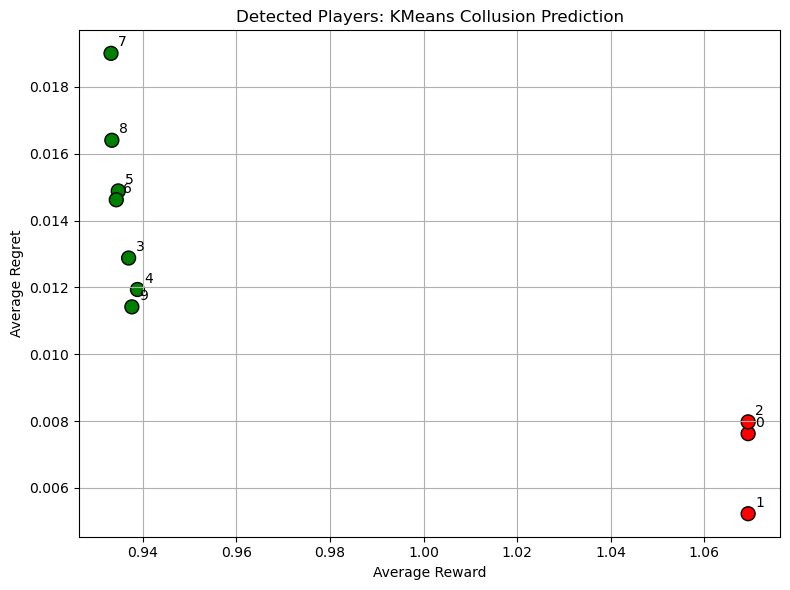

Detected colluders: [0 1 2]
Detected honest players: [3 4 5 6 7 8 9]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# === Load saved model and mapping ===
kmeans = joblib.load("kmeans_model.pkl")
mapping = joblib.load("kmeans_mapping.pkl")

# === Load final game data ===
history_rewards = np.load('game_data/history_rewards.npy')
history_regrets = np.load('game_data/history_regrets.npy')
num_players, num_rounds = history_rewards.shape

# === Construct features ===
avg_rewards = history_rewards.mean(axis=1)
avg_regrets = history_regrets.mean(axis=1)
features = np.vstack([avg_rewards, avg_regrets]).T

# === Predict using trained KMeans model ===
cluster_labels = kmeans.predict(features)
predicted_labels = np.array([mapping[c] for c in cluster_labels])  # 1 = colluder, 0 = honest

# === Visualization ===
plt.figure(figsize=(8, 6))
colors = ['red' if lbl == 1 else 'green' for lbl in predicted_labels]
plt.scatter(avg_rewards, avg_regrets, c=colors, s=100, edgecolors='black')
for i in range(num_players):
    plt.annotate(f"{i}", (avg_rewards[i], avg_regrets[i]), textcoords="offset points", xytext=(5, 5))
plt.xlabel("Average Reward")
plt.ylabel("Average Regret")
plt.title("Detected Players: KMeans Collusion Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print groupings
print("Detected colluders:", np.where(predicted_labels == 1)[0])
print("Detected honest players:", np.where(predicted_labels == 0)[0])


DTW (Dynamic Time Warping) compares entire reward time-series curves.
- Colluders tend to have very synchronized reward growth because they coordinate.
- Honest players have independent noisy growth paths.
- We cluster based on DTW distances instead of just final averages.
- This makes detection much more resilient against noise and time-based variance.

In [23]:
!pip install tslearn

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


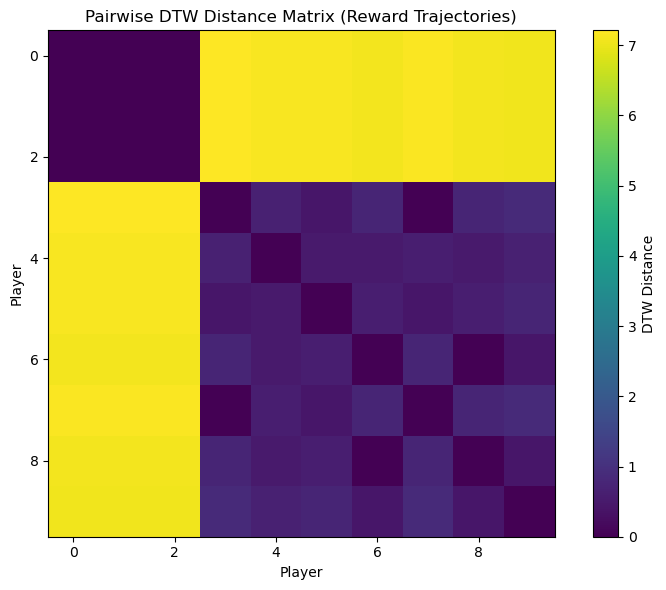

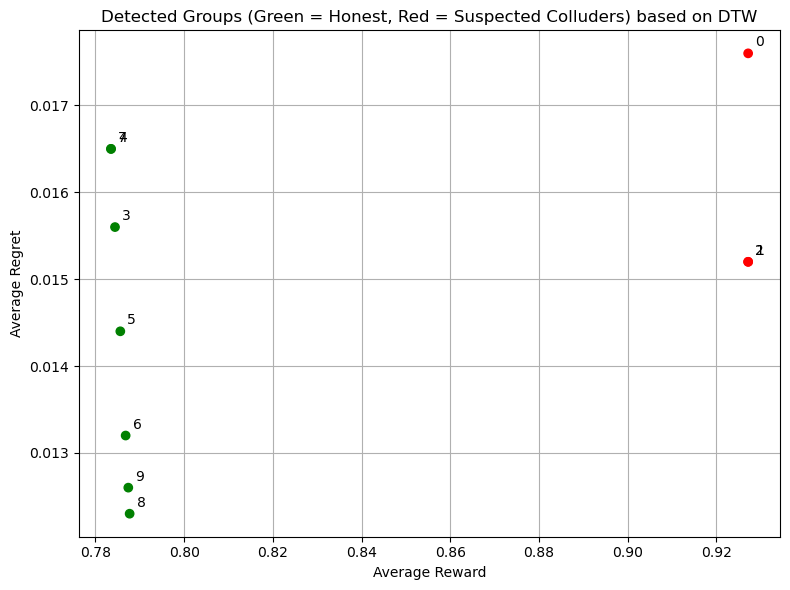

Detected 'colluder' players (label=1): [0 1 2]
Detected 'honest' players (label=0): [3 4 5 6 7 8 9]


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from tslearn.metrics import dtw
from sklearn.cluster import AgglomerativeClustering

# ==== Load history arrays ====
history_rewards = np.load('game_implementation/history_rewards.npy')
history_regrets = np.load('game_implementation/history_regrets.npy')

num_players, num_rounds = history_rewards.shape

# ==== Build Time Series Features ====
# You can choose rewards or regrets (both work, but rewards usually show collusion better)
series = history_rewards  # shape (num_players, num_rounds)

# ==== Compute Pairwise DTW Distances ====
dtw_distance_matrix = np.zeros((num_players, num_players))

for i in range(num_players):
    for j in range(i+1, num_players):
        distance = dtw(series[i], series[j])
        dtw_distance_matrix[i, j] = distance
        dtw_distance_matrix[j, i] = distance

# ==== Clustering ====
# Agglomerative clustering on the DTW distance matrix
clustering = AgglomerativeClustering(
    n_clusters=2,         # Assume 2 groups: colluders vs honest
    affinity='precomputed',
    linkage='average'
)
labels = clustering.fit_predict(dtw_distance_matrix)

# ==== Plot DTW Distance Matrix ====
plt.figure(figsize=(8, 6))
plt.imshow(dtw_distance_matrix, cmap='viridis')
plt.colorbar(label='DTW Distance')
plt.title('Pairwise DTW Distance Matrix (Reward Trajectories)')
plt.xlabel('Player')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# ==== Scatter the players (using average reward and regret for visualization) ====
avg_rewards = history_rewards.mean(axis=1)
avg_regrets = history_regrets.mean(axis=1)

colors = ['red' if label == 1 else 'green' for label in labels]

plt.figure(figsize=(8, 6))
plt.scatter(avg_rewards, avg_regrets, c=colors)
for i in range(num_players):
    plt.annotate(str(i), (avg_rewards[i], avg_regrets[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel('Average Reward')
plt.ylabel('Average Regret')
plt.title('Detected Groups (Green = Honest, Red = Suspected Colluders) based on DTW')
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Output results ====
print("Detected 'colluder' players (label=1):", np.where(labels == 1)[0])
print("Detected 'honest' players (label=0):", np.where(labels == 0)[0])


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

=== Confusion Matrix ===
[[1 0]
 [0 1]]
=== FINAL Detected Colluders ===
[0 1 2]


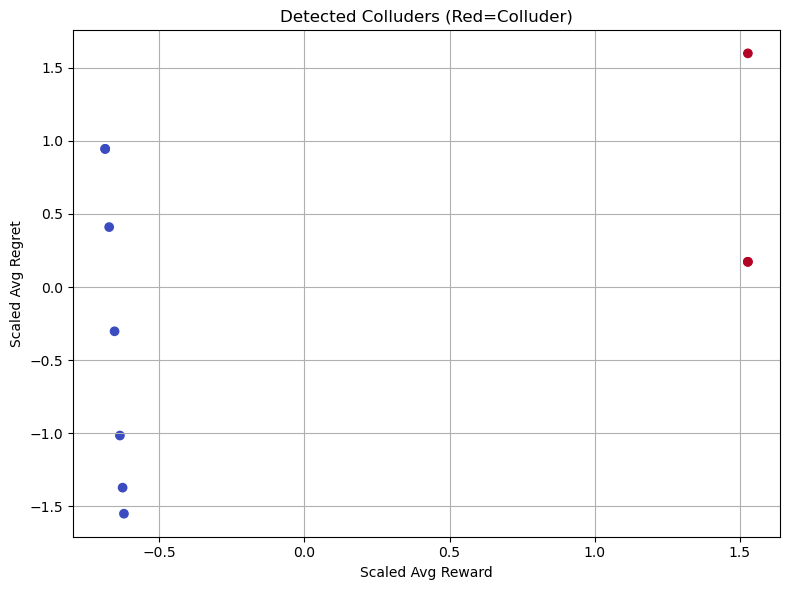

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# === LOAD DATA ===
history_rewards = np.load('game_implementation/history_rewards.npy')
history_regrets = np.load('game_implementation/history_regrets.npy')
action_history = np.load('game_implementation/history_actions.npy')  # assuming you saved it too

num_players, num_rounds = history_rewards.shape

# === MANUAL LABELS ===
# Assume you know players 0,1,2 were colluders
true_colluders = [0,1,2]
labels_true = np.zeros(num_players)
labels_true[true_colluders] = 1  # 1 = colluder, 0 = honest

# === FEATURE EXTRACTION ===

# 1. Average reward
avg_reward = history_rewards.mean(axis=1)

# 2. Average regret
avg_regret = history_regrets.mean(axis=1)

# 3. Entropy of action choices (lower entropy = more predictable = possible collusion)
def entropy(p):
    p = np.array(p)
    p = p[p > 0]
    return -np.sum(p * np.log(p))

entropy_list = []
for i in range(num_players):
    counts = np.bincount(action_history[i], minlength=np.max(action_history)+1)
    probs = counts / counts.sum()
    entropy_list.append(entropy(probs))
entropy_list = np.array(entropy_list)

# 4. Standard deviation of rewards over time (colluders are smoother?)
reward_std = np.std(history_rewards, axis=1)

# Stack features
features = np.vstack([avg_reward, avg_regret, entropy_list, reward_std]).T

# === STANDARDIZE FEATURES ===
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# === TRAIN ML MODEL ===
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_true, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

# === EVALUATE ===
y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

# === Predict all players ===
final_pred = clf.predict(features_scaled)

print("=== FINAL Detected Colluders ===")
print(np.where(final_pred == 1)[0])

# === PLOT for sanity check ===
plt.figure(figsize=(8,6))
plt.scatter(features_scaled[:,0], features_scaled[:,1], c=final_pred, cmap='coolwarm')
plt.xlabel('Scaled Avg Reward')
plt.ylabel('Scaled Avg Regret')
plt.title('Detected Colluders (Red=Colluder)')
plt.grid(True)
plt.tight_layout()
plt.show()
